In [8]:
!pip install -q kagglehub lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 38.4 MB/s eta 0:00:00


In [9]:
import os
import glob
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as T
import lightning as L
import torchvision
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import kagglehub
import shutil

In [11]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [10]:
cache_path = kagglehub.dataset_download("andrewmvd/drive-digital-retinal-images-for-vessel-extraction")
target_dir = "./drive_data"
if os.path.exists(target_dir):
     shutil.rmtree(target_dir)
shutil.copytree(cache_path, target_dir)
print("Датасет сохранен в:", target_dir)

Датасет сохранен в: ./drive_data


In [16]:
DRIVE_DIR = os.path.join(target_dir, "DRIVE")
TRAIN_IMG_DIR = os.path.join(DRIVE_DIR, "training/images")
TRAIN_MASK_DIR = os.path.join(DRIVE_DIR, "training/1st_manual") # размеченные экспертами бинарные маски сосудов
TRAIN_FOV_DIR = os.path.join(DRIVE_DIR, "training/mask") # область (круг), в пределах которой рассмтаривается снимок

TEST_IMG_DIR = os.path.join(DRIVE_DIR, "test/images")
TEST_MASK_DIR = os.path.join(DRIVE_DIR, "test/1st_manual")
TEST_FOV_DIR = os.path.join(DRIVE_DIR, "test/mask")

In [29]:
def load_images(img_dir, mask_dir, fov_dir):
    img_files = sorted(glob.glob(os.path.join(img_dir, '*.tif')))
    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.gif')))
    fov_files = sorted(glob.glob(os.path.join(fov_dir, '*.gif')))

    images, masks, fov_masks = [], [], []
    for img_path, mask_path, fov_path in zip(img_files, mask_files, fov_files):
        img = Image.open(img_path).convert("RGB")
        img = np.array(img, dtype=np.float32) / 255.0
        images.append(img)

        mask = Image.open(mask_path)
        mask = np.array(mask, dtype=np.float32)
        mask[mask>0] = 1.0
        mask = np.expand_dims(mask, axis=-1)
        masks.append(mask)

        fov = Image.open(fov_path)
        fov = np.array(fov, dtype=np.float32)
        fov[fov > 0] = 1.0
        fov = np.expand_dims(fov, axis=-1)
        fov_masks.append(fov)

    return np.array(images), np.array(masks), np.array(fov_masks)
images, masks, fov_masks = load_images(TRAIN_IMG_DIR, TRAIN_MASK_DIR, TRAIN_FOV_DIR)
print("Number of train images:", len(images))

Number of train images: 20


In [31]:
class PatchDataset(Dataset):
    def __init__(self, images, masks, patch_size=128, stride=64):
          self.patch_size = patch_size
          self.patches = []
          img_h, img_w = images.shape[1], images.shape[2]
          num_img = images.shape[0]
          for i in range(num_img):
              for y in range(0, img_h - patch_size + 1, stride):
                  for x in range(0, img_w - patch_size + 1, stride):
                      mask_patch = masks[i, y:y+patch_size, x:x+patch_size]
                      if np.sum(mask_patch) > 0:
                          img_patch = images[i, y:y+patch_size, x:x+patch_size]
                          self.patches.append((img_patch, mask_patch))
    def __len__(self):
          return len(self.patches)
    def __getitem__(self, idx):
          img, mask = self.patches[idx]
          img = torch.from_numpy(img).permute(2, 0, 1).float()
          mask = torch.from_numpy(mask).permute(2, 0, 1).float()
          return img, mask
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, random_state=42, test_size=0.1)
train_patch_dataset = PatchDataset(X_train, Y_train)
val_patch_dataset = PatchDataset(X_val, Y_val)

In [32]:
train_dataloader = DataLoader(train_patch_dataset, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_patch_dataset, batch_size=16, shuffle=False, num_workers=2)

Примеры изображений и масок из тестового набора


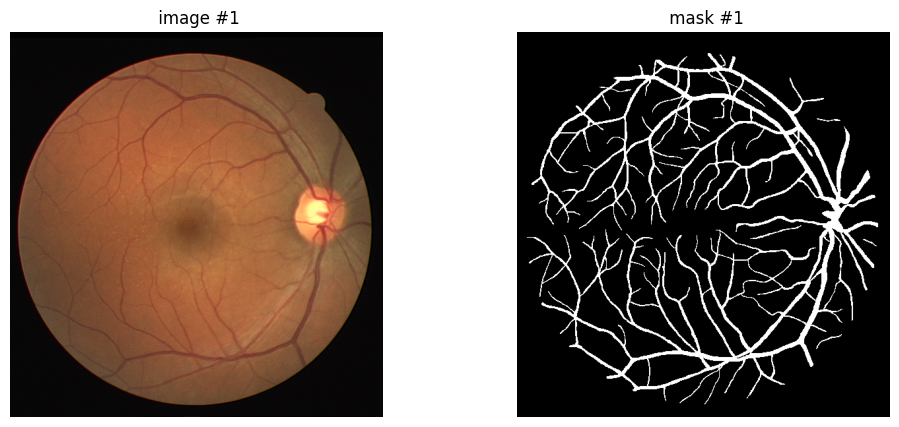

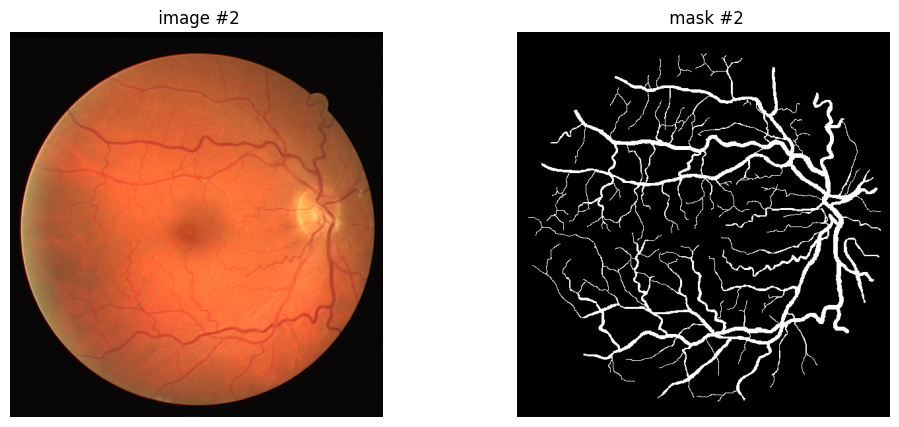

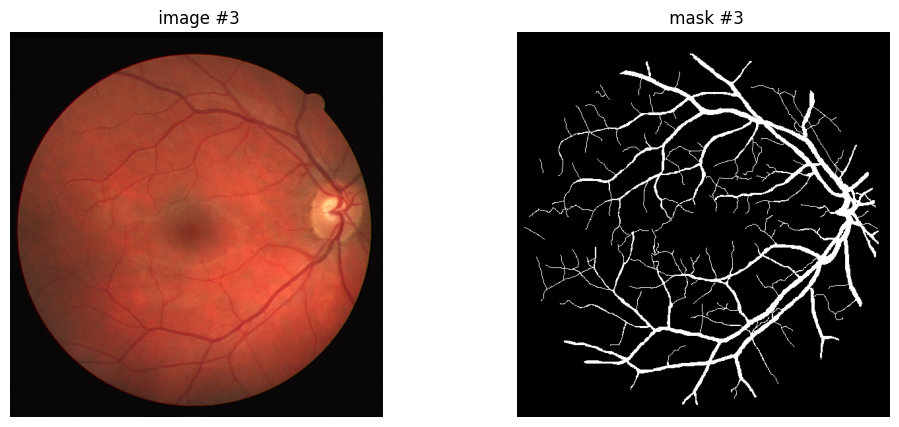

In [34]:
import matplotlib.pyplot as plt

num_samples = 3

print("Примеры изображений и масок из тестового набора")

for i in range(num_samples):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f" image #{i+1}")
    plt.imshow(X_train[i])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f" mask #{i+1}")
    plt.imshow(Y_train[i], cmap='gray')
    plt.axis('off')

    plt.show()

In [35]:
import numpy as np

class Metrics:
    def __init__(self, preds, y_true, threshold=0.5):
        self.preds = preds
        self.y_true = y_true
        self.threshold = threshold
        self.preds_bin = (preds > threshold).astype(np.float32)
        y_true_f = y_true.flatten()
        preds_f = self.preds_bin.flatten()

        self.TP = np.sum((preds_f == 1) & (y_true_f == 1))
        self.FP = np.sum((preds_f == 1) & (y_true_f == 0))
        self.TN = np.sum((preds_f == 0) & (y_true_f == 0))
        self.FN = np.sum((preds_f == 0) & (y_true_f == 1))

    def iou_score(self, eps=1e-6):
        intersection = self.TP
        union = self.TP + self.FP + self.FN
        return (intersection + eps) / (union + eps)

    def dice_score(self, eps=1e-6):
        return (2 * self.TP + eps) / (2 * self.TP + self.FP + self.FN + eps)

    def recall(self, eps=1e-6):
        return self.TP / (self.TP + self.FN + eps)

    def specificity(self, eps=1e-6):
        return self.TN / (self.TN + self.FP + eps)

    def accuracy(self, eps=1e-6):
        return (self.TP + self.TN) / (self.TP + self.TN + self.FP + self.FN + eps)

    def report(self):
        print(f"Dice coefficient: {self.dice_score():.4f}")
        print(f"IoU:               {self.iou_score():.4f}")
        print(f"Accuracy:          {self.accuracy():.4f}")
        print(f"Sensitivity:       {self.recall():.4f}")
        print(f"Specificity:       {self.specificity():.4f}")